# 14.03.20

**Author:** Miron Rogovets

---

### Task 7.

Open __Warranty.dta__ file. 

The aim of analysis is to find out what circumstances encourage customers to purchase extended warranties after a major appliance purchase. The response variable is an indicator of whether or not a warranty is purchased (Bought). The predictor variables are:
* Customer’s gender (Gender)
* Customer’s age (Age)
* Whether a gift is offered with the warranty or not (Gift)
* Price of the appliance (Price100)
* Customer’s race (Race)

Use the binary logistic regression to analyze the data. 
1. Specify the regression equation (the linear part of the formula). 
2. Assess the goodness-of-fit of the model and interpret the results of the analysis. 
3. Interpret the influence of any predictor variable on the dependent variable using Exp(b).
4. Which gradients are statistically significant? 
5. What is the percentage of correctly predicted cases by the model?
6. Do the diagnostics of the model. 
   - Are the residuals normally distributed? 
   - Are there any outliers? If yes, how many? 
   - Test the multicollinearity.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest
import statsmodels.formula.api as sm
from sklearn.metrics import roc_curve, auc

In [2]:
df = pd.read_stata('data/WARRANTY.dta')
print(df.shape)
df.head()

(50, 6)


,Bought,Gender,Gift,Age,Race,Price100
0,Yes,Male,Yes,45.0,White,75.0
1,No,Male,No,34.0,African American,125.0
2,Yes,Male,Yes,26.0,Hispanic,150.0
3,Yes,Female,Yes,54.0,African American,38.5
4,No,Female,No,44.0,White,17.0


Check if we have any missing values

In [3]:
df.isna().sum()

Bought      0
Gender      0
Gift        0
Age         0
Race        0
Price100    0
dtype: int64

We should also get rid of spaces in <code>Race</code> column

In [4]:
df['Race'] = df.Race.apply(lambda x: x.replace(' ', ''))
df.head()

,Bought,Gender,Gift,Age,Race,Price100
0,Yes,Male,Yes,45.0,White,75.0
1,No,Male,No,34.0,AfricanAmerican,125.0
2,Yes,Male,Yes,26.0,Hispanic,150.0
3,Yes,Female,Yes,54.0,AfricanAmerican,38.5
4,No,Female,No,44.0,White,17.0


In [5]:
print(df.Race.value_counts())

White              16
Hispanic           15
AfricanAmerican    12
Other               7
Name: Race, dtype: int64


In [6]:
data_encoded = pd.get_dummies(df, prefix=['Bought', 'Gender', 'Gift', 'Race'], 
                              columns = ['Bought', 'Gender', 'Gift', 'Race'])
data_encoded.head()

,Age,Price100,Bought_No,Bought_Yes,Gender_Female,Gender_Male,Gift_No,Gift_Yes,Race_White,Race_AfricanAmerican,Race_Hispanic,Race_Other
0,45.0,75.0,0,1,0,1,0,1,1,0,0,0
1,34.0,125.0,1,0,0,1,1,0,0,1,0,0
2,26.0,150.0,0,1,0,1,0,1,0,0,1,0
3,54.0,38.5,0,1,1,0,0,1,0,1,0,0
4,44.0,17.0,1,0,1,0,1,0,1,0,0,0


We use <code>Race_Other</code> as a reference variable for dummy encoded _Race_

In [7]:
data = data_encoded.drop(columns=['Bought_No', 'Gender_Female', 'Gift_No', 'Race_Other']).copy()
data.head()

,Age,Price100,Bought_Yes,Gender_Male,Gift_Yes,Race_White,Race_AfricanAmerican,Race_Hispanic
0,45.0,75.0,1,1,1,1,0,0
1,34.0,125.0,0,1,0,0,1,0
2,26.0,150.0,1,1,1,0,0,1
3,54.0,38.5,1,0,1,0,1,0
4,44.0,17.0,0,0,0,1,0,0


In [8]:
data.rename(columns={'Bought_Yes': 'Bought', 'Gender_Male': 'Gender', 'Gift_Yes':'Gift'}, inplace=True)
data.head()

,Age,Price100,Bought,Gender,Gift,Race_White,Race_AfricanAmerican,Race_Hispanic
0,45.0,75.0,1,1,1,1,0,0
1,34.0,125.0,0,1,0,0,1,0
2,26.0,150.0,1,1,1,0,0,1
3,54.0,38.5,1,0,1,0,1,0
4,44.0,17.0,0,0,0,1,0,0


We cleaned our data, so now we can create and fit our model

In [9]:
formula_str = 'Bought ~ ' + ' + '.join(data.columns.drop('Bought'))
formula_str

'Bought ~ Age + Price100 + Gender + Gift + Race_White + Race_AfricanAmerican + Race_Hispanic'

In [10]:
model = sm.logit(formula=formula_str, data=data)
fitted = model.fit()
print(fitted.summary())

Optimization terminated successfully.
         Current function value: 0.161342
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:                 Bought   No. Observations:                   50
Model:                          Logit   Df Residuals:                       42
Method:                           MLE   Df Model:                            7
Date:                Fri, 20 Mar 2020   Pseudo R-squ.:                  0.7279
Time:                        19:16:01   Log-Likelihood:                -8.0671
converged:                       True   LL-Null:                       -29.648
Covariance Type:            nonrobust   LLR p-value:                 3.105e-07
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              -12.0178     14.921     -0.805      0.421     -41.263      17.22

A bit cleaner output:

In [11]:
print(fitted.summary2())

                            Results: Logit
Model:                 Logit             Pseudo R-squared:  0.728     
Dependent Variable:    Bought            AIC:               32.1342   
Date:                  2020-03-20 19:16  BIC:               47.4304   
No. Observations:      50                Log-Likelihood:    -8.0671   
Df Model:              7                 LL-Null:           -29.648   
Df Residuals:          42                LLR p-value:       3.1050e-07
Converged:             1.0000            Scale:             1.0000    
No. Iterations:        12.0000                                        
----------------------------------------------------------------------
                      Coef.   Std.Err.    z    P>|z|   [0.025   0.975]
----------------------------------------------------------------------
Intercept            -12.0178  14.9213 -0.8054 0.4206 -41.2630 17.2275
Age                    0.0915   0.0563  1.6242 0.1043  -0.0189  0.2019
Price100               0.0913   0.

### Model description

In [12]:
coefs = pd.DataFrame()
coefs['Coefs'] = fitted.params[1:]
coefs['Features'] = fitted.params.index[1:]
coefs.set_index('Features', inplace=True)
print('Intercept = ', fitted.params[0])
coefs

Intercept =  -12.017773834906015


,Coefs
Features,
Age,0.091482
Price100,0.091326
Gender,-3.772301
Gift,2.715491
Race_White,3.773168
Race_AfricanAmerican,1.162994
Race_Hispanic,6.347211


We have the following equation for linear part of the formula:

In [13]:
print('Z = {:3f} + {}'
      .format(fitted.params[0], ' + '.join(
          ['{:.3f}*{}'.format(param, index) for (param, index) in zip(fitted.params[1:], fitted.params.index[1:])]
      )))

Z = -12.017774 + 0.091*Age + 0.091*Price100 + -3.772*Gender + 2.715*Gift + 3.773*Race_White + 1.163*Race_AfricanAmerican + 6.347*Race_Hispanic


#### Goodness-of-fit test

In [14]:
fpr, tpr, _ = roc_curve(data.Bought, fitted.predict())
roc_auc = auc(fpr, tpr)

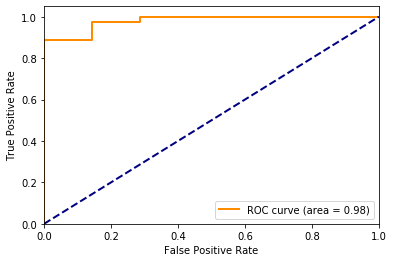

In [15]:
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

The model has a quality of 98%

#### Interpretation

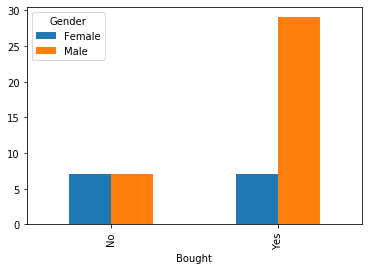

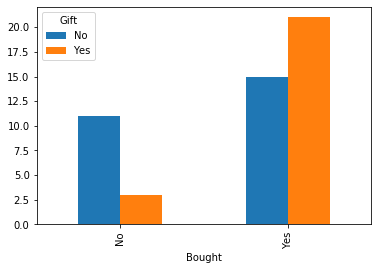

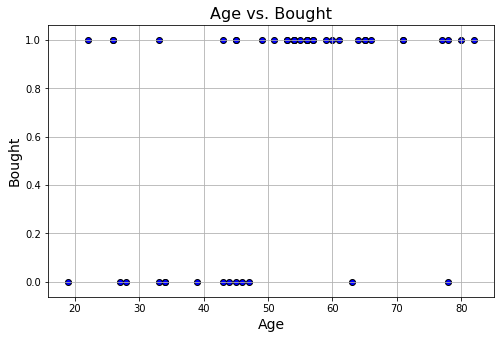

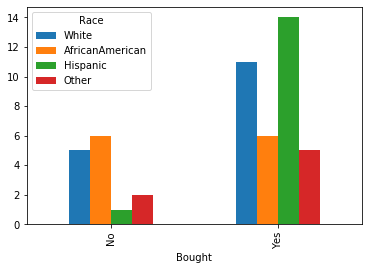

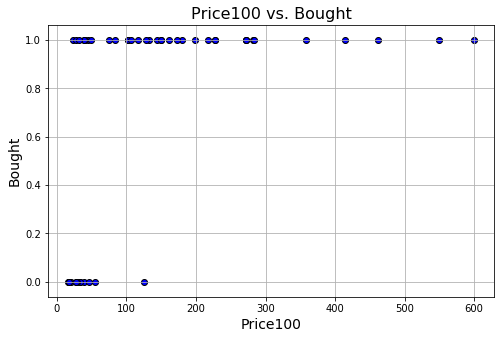

In [16]:
for c in df.columns[1:]:
    if c == 'Age' or c == 'Price100':
        plt.figure(figsize=(8,5))
        plt.title('{} vs. Bought'.format(c), fontsize=16)
        plt.scatter(x=data[c], y=data.Bought, color='blue',edgecolor='k')
        plt.grid(True)
        plt.xlabel(c, fontsize=14)
        plt.ylabel('Bought', fontsize=14)
        plt.show()
    else:
        ct = pd.crosstab(df.Bought, df[c])
        ct.plot.bar()

In [17]:
coefs['OddsRatio'] = np.exp(coefs.Coefs)
coefs

,Coefs,OddsRatio
Features,,
Age,0.091482,1.095797
Price100,0.091326,1.095626
Gender,-3.772301,0.022999
Gift,2.715491,15.112032
Race_White,3.773168,43.517717
Race_AfricanAmerican,1.162994,3.199498
Race_Hispanic,6.347211,570.898314


- One unit increase in __Age__ increases probabily of purchasing warranty by __9%__
- One unit increase in __Pice100__ increases probabily of purchasing warranty by __9%__
- __Females__ are __33__ times more likely to purchase warranty
- Purchase probability is __15__ times greater with __gifts__
- People of __Hispanic__ and __White__ races are much more likely to purchase warranty than others

In [18]:
def yes_no(p_value, level = 0.05):
    if abs(p_value) < level:
        return 'significant'
    else:
        return 'non-significant'

In [19]:
pvals = pd.DataFrame()
pvals['p_values'] = fitted.pvalues[1:]
pvals['5% level']= pvals['p_values'].apply(yes_no)
pvals['p_values'] = pvals['p_values'].map('{:.3f}'.format)
pvals['Features'] = fitted.params.index[1:]
pvals.set_index('Features',inplace=True)
pvals

,p_values,5% level
Features,,
Age,0.104,No
Price100,0.067,No
Gender,0.142,No
Gift,0.083,No
Race_White,0.785,No
Race_AfricanAmerican,0.933,No
Race_Hispanic,0.652,No


All variables are not statistically significant at __5%__ level, however, some of them _(Price100 & Gift)_ are significant at __10%__.

In [21]:
pvals['10% level'] = fitted.pvalues[1:].apply(lambda x: yes_no(x, level=0.1))
pvals

,p_values,5% level,10% level
Features,,,
Age,0.104,No,No
Price100,0.067,No,Yes
Gender,0.142,No,No
Gift,0.083,No,Yes
Race_White,0.785,No,No
Race_AfricanAmerican,0.933,No,No
Race_Hispanic,0.652,No,No


#### Confusion matrix & accuracy

In [22]:
cm = fitted.pred_table()
print('TP: {} | FN: {}\n-------------------\nFP: {}  | TN: {}'.format(cm[0,0], cm[0,1], cm[1,0], cm[1,1]))

TP: 11.0 | FN: 3.0
-------------------
FP: 1.0  | TN: 35.0


Text(0.5, 257.44, 'Predicted label')

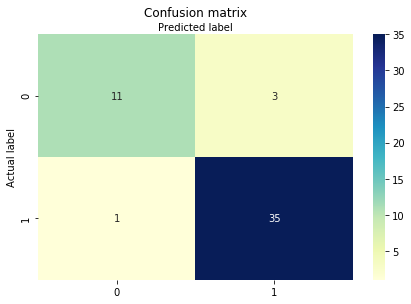

In [23]:
names = [0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(names))
plt.xticks(tick_marks, names)
plt.yticks(tick_marks, names)
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.title('Confusion matrix', y = 1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [24]:
accuracy = (cm[0,0] + cm[1,1]) / sum(sum(cm))
print('Accuracy = {}'.format(accuracy))

Accuracy = 0.92


#### Model diagnostics

To test whether the residuals are normally distributed we define following hypothesis and apply Kolmogorov-Smirnov test:
- H0: the distribution of residuals **is not** significantly different form the normal distribution
- H1: the distribution of residuals **is** significantly different form the normal distribution

In [26]:
resid_pearson = fitted.resid_pearson
resid_pearson.fillna(0.0, inplace=True)
p = kstest(resid_pearson, 'norm').pvalue
print('P-value: {:.3f}'.format(p))
if p <= 0.05:
    print('Reject H0')
else:
    print('Accept H0')

P-value: 0.000
Reject H0


_The distribution of residuals is different from normal distribution._

Check if we have any outliers

In [27]:
sum(abs(resid_pearson) > 2.)

0

We can use correlation matrix for multicollinearity:

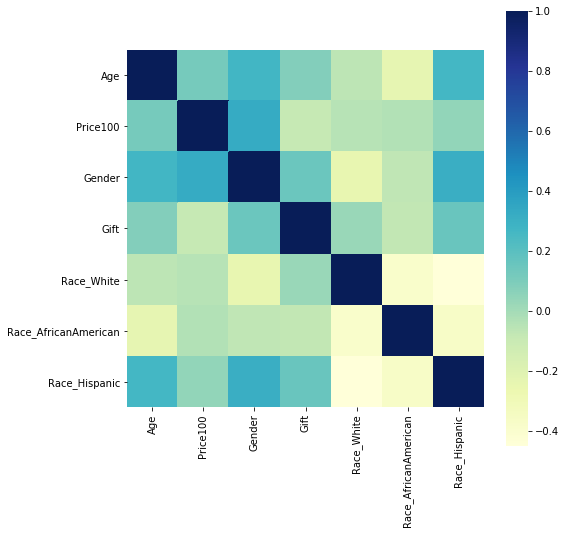

In [28]:
plt.figure(figsize=(8, 8))
sns.heatmap(data.drop(columns=['Bought']).corr(), square = True, cmap='YlGnBu')
plt.show()

There is no multicollinearity as we do not have highly correlated variables